# Run memento-GLM for Cano-Gamez datasets

In [1059]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import scanpy as sc
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from patsy import dmatrix, dmatrices 
import statsmodels.api as sm
import logging
import pickle as pkl
from scipy.optimize import minimize
import os

In [1060]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1061]:
%autoreload 2

In [1062]:
data_path = '/data_volume/memento/method_comparison/canogamez/'

### Cano Gamez datasets

In [1063]:
datasets = [
 'CD4_Memory-Th0',
 'CD4_Memory-Th2',
 'CD4_Memory-Th17',
 'CD4_Memory-iTreg',
 'CD4_Naive-Th0',
 'CD4_Naive-Th2',
 'CD4_Naive-Th17',
 'CD4_Naive-iTreg']

### Run memento

In [1064]:
import os

In [1065]:
import sys
sys.path.append('/home/ssm-user/Github/memento')

import memento.model.rna as rna

logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

In [1066]:
trial = 1
dataset = 'CD4_Memory-Th0'
    
print(dataset)
ct, stim = dataset.split('-')

adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(dataset, trial))
dispersion = pd.read_csv(data_path + 'sc_results/{}_{}_dispersions.csv'.format(dataset, trial), index_col=0)
# gene_list = dispersions['gene'].tolist()
# dispersions = dispersions['dispersion'].tolist()
adata.obs['q'] = 0.07
adata.X = adata.X.astype(float)

rna.MementoRNA.setup_anndata(
        adata=adata,
        q_column='q',
        label_columns=['donor.id', 'cytokine.condition'],
        num_bins=30)

adata = adata[:, dispersion.index]

model = rna.MementoRNA(adata=adata)

model_save_name = f'{dataset}_estimates'

if model_save_name in os.listdir():
    model.load_estimates(model_save_name)
else:
    model.compute_estimate(
        estimand='mean',
        get_se=True,
        n_jobs=30,
    )
    model.save_estimates(model_save_name)

CD4_Memory-Th0


2023-07-13 19:52:45 41046   INFO     setup_anndata: creating groups
2023-07-13 19:52:45 41046   INFO     setup_anndata: computing cell sizes


In [956]:
adata.obs.head(2)

,cell.type,cytokine.condition,donor.id,batch.10X,nGene,nUMI,percent.mito,S.Score,G2M.Score,Phase,cluster.id,effectorness,batch,q,memento_group,memento_size_factor,memento_approx_size_factor
M_Th0_r1_AGGTCATTCATCGCTC-0,CD4_Memory,Th0,D1,1,1572,8205,0.002073,-0.096113,-0.015126,G1,Mitotic,0.672442,0,0.07,memento_group^D1^Th0,1.211658,1.136858
M_Th0_r1_CGCGGTAGTACGAAAT-0,CD4_Memory,Th0,D1,1,4810,26936,0.038095,0.066206,-0.055787,S,TN (Th2),0.541871,0,0.07,memento_group^D1^Th0,2.080627,2.155205


<Axes: xlabel='cytokine.condition', ylabel='nUMI'>

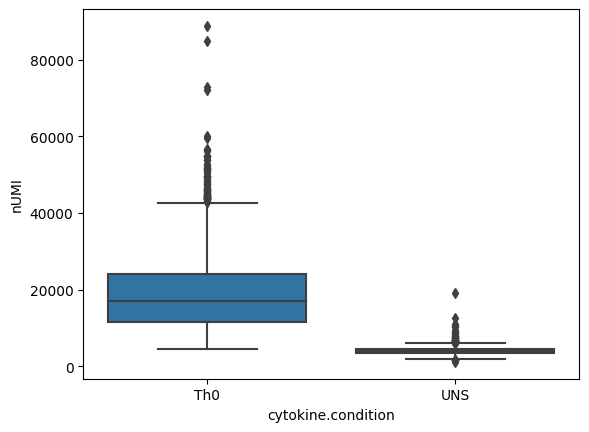

In [957]:
sns.boxplot(y='nUMI', x='cytokine.condition', data=adata.obs)

In [958]:
def quasi_nb_var(mean, scale, dispersion):
    
    return scale*(mean + dispersion*mean**2)


def quasi_nb_objective(scale, dispersion, mean, variance):
    
    pred_y = np.log(quasi_nb_var(mean, scale, dispersion))
    y = np.log(variance)
    
    return ((pred_y-y)**2).mean()
    

def fit_quasi_nb(mean, variance):

    dispersion0 = 1
    scale0 = np.median((mean/variance))
        
    optim_obj = lambda params: quasi_nb_objective(params[0], params[1], mean, variance)

    res =  minimize(
        optim_obj, 
        [scale0, dispersion0],
        bounds=[(1e-5,None), (1e-10, 10)],
    )
    return res.x

In [959]:
test_estimates = model.estimates

In [1067]:
n_groups = test_estimates['mean'].shape[0]

# "Counts" to use in GLM
expr = (
    test_estimates['mean']/
    model.adata.uns['memento']['umi_depth']*
    test_estimates['total_umi'].values)
count_multiplier = model.estimates['total_umi'].values/model.adata.uns['memento']['umi_depth']
sampling_variance =  (model.estimates['se_mean']**2)*count_multiplier**2

# Fit within-sample variance function parameters
intra_var_scale = np.zeros(n_groups)
intra_var_dispersion = np.zeros(n_groups)
for group_idx in range(n_groups):
    intra_var_scale[group_idx], intra_var_dispersion[group_idx] = fit_quasi_nb(    
        mean = expr.iloc[group_idx].values,
        variance = sampling_variance.iloc[group_idx].values)

In [1068]:
condition = 'UNS'
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['mouse'] = df.index.str.split('^').str[1]
df['stim'] = df.index.str.split('^').str[2]
cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
stim_df = (df[['stim']]==condition).astype(float)
cov_df = sm.add_constant(cov_df)

In [1069]:
design_matrix = pd.concat([cov_df, stim_df[['stim']]], axis=1)
# design_matrix = sm.add_constant(stim_df[['stim']])

In [1070]:
pred_list = []

for gene_idx in range(expr.shape[1]):
    endog = expr.iloc[:, gene_idx]
    exog=design_matrix
    offset = test_estimates['total_umi']['total_umi']#np.ones(expr.shape[0])*10000
    fit = sm.GLM(
        endog.values, 
        exog, 
        offset=np.log(offset),
        family=sm.families.Poisson()).fit()
    pred = fit.predict()
    pred_list.append(pred)

In [1071]:
pred = pd.DataFrame(pred_list, index=expr.columns, columns=expr.index).T.values#.mean(axis=0)

In [1072]:
resid_variance = (np.abs((pred- expr))**2).values#.mean(axis=0)

In [1073]:
alpha = (resid_variance/(pred**2)).mean(axis=1)

In [1099]:
x = np.log(pred).ravel()
y = np.log(resid_variance).ravel()
x_high = x[y < np.quantile(y, 0.9)]
y_high = y[y < np.quantile(y, 0.9)]
slope, inter, _, _, _ = stats.linregress(x_high, y_high)
np.exp(inter)

0.4165808877210226

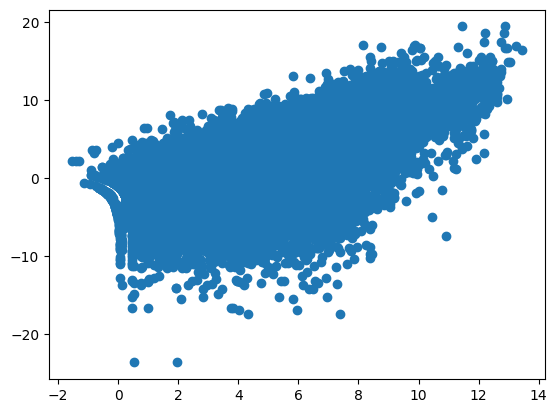

In [1078]:
plt.scatter(np.log(pred), np.log(resid_variance))

In [1027]:
resid_variance

array([[6.35633421e+00, 1.39995608e+02, 2.03444244e+00, ...,
        5.75888179e-04, 1.81973916e+00, 8.33410939e-03],
       [6.35633421e+00, 1.39995608e+02, 2.03444244e+00, ...,
        5.75888179e-04, 1.81973916e+00, 8.33410938e-03],
       [3.23598374e+00, 7.76358600e-02, 1.87423839e+00, ...,
        1.38434878e-01, 1.27075835e-02, 5.69028678e-02],
       ...,
       [2.43214513e-02, 2.36756412e+01, 1.00908947e-01, ...,
        5.72686696e-02, 6.24350263e-01, 1.18885192e-01],
       [3.20740722e-01, 5.24877640e+01, 6.13902405e+00, ...,
        4.03701112e-01, 1.98996986e-01, 2.23884093e-04],
       [3.20740722e-01, 5.24877640e+01, 6.13902405e+00, ...,
        4.03701112e-01, 1.98996986e-01, 2.23884090e-04]])

In [967]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [968]:
dds = DeseqDataSet(
    counts=expr.round(),
    clinical=df,
    design_factors=['mouse', 'stim'],
    refit_cooks=True,
    n_cpus=8,
)

In [969]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.43 seconds.

Fitting dispersion trend curve...
... done in 3.23 seconds.

Fitting MAP dispersions...
... done in 1.33 seconds.

Fitting LFCs...
... done in 0.97 seconds.

Refitting 0 outliers.



In [1024]:
v = model.estimates['se_mean'].values**2*model.estimates['cell_count'].values
m = model.estimates['mean'].values

In [1025]:
dds.varm['MAP_dispersions']

array([0.0148196 , 0.0313454 , 0.27152459, ..., 0.13168906, 0.17360579,
       0.25280632])

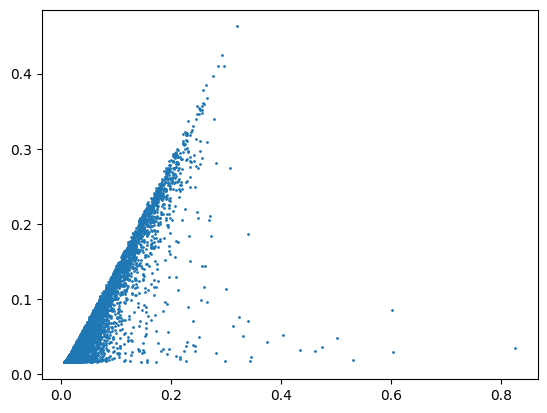

In [1026]:
plt.scatter(dds.varm['MAP_dispersions'], dds.varm['fitted_dispersions'], s=1)

In [1020]:
dds.varm['MAP_dispersions']

array([0.0148196 , 0.0313454 , 0.27152459, ..., 0.13168906, 0.17360579,
       0.25280632])

In [1036]:
# Fit within-sample variance function parameters
var_power = np.zeros(n_groups)
var_factor = np.zeros(n_groups)
for group_idx in range(n_groups):

    x,y = np.log(pred[group_idx]), np.log(resid_variance[group_idx])
    x_high = x[x > np.quantile(x, 0.9)]
    y_high = y[x > np.quantile(x, 0.9)]
    var_power[group_idx], var_factor[group_idx], _, _, _ = stats.linregress(x, y)

correction = var_power-var_power.min()

In [894]:
var_power.max()-var_power.min()

0.4594432947458116

LinregressResult(slope=1.5761418127790807, intercept=-3.3606086091796827, rvalue=0.695086867615771, pvalue=0.0, stderr=0.015784813744203898, intercept_stderr=0.05174920088911243)

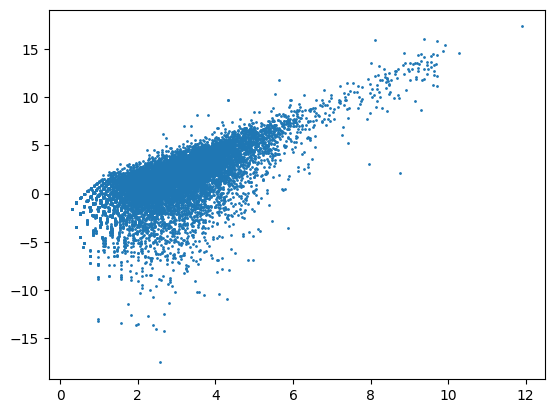

In [896]:
plt.scatter(np.log(pred[1]), np.log(resid_variance[1]), s=1)
stats.linregress(np.log(pred[1]), np.log(resid_variance[1]))

LinregressResult(slope=1.6508722192304677, intercept=-3.6775780697089857, rvalue=0.745791216241663, pvalue=0.0, stderr=0.014278639669255064, intercept_stderr=0.0916036505814403)

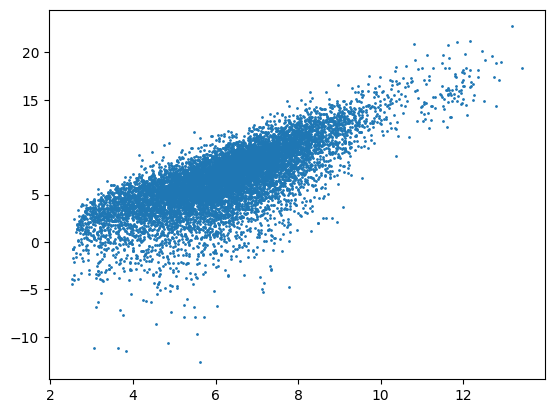

In [897]:
plt.scatter(np.log(pred[0]), np.log(resid_variance[0]), s=1)
stats.linregress(np.log(pred[0]), np.log(resid_variance[0]))

In [174]:
predicted_var = mean_hat**2

In [175]:
var_ratio = resid_variance/predicted_var

In [176]:
np.median(var_ratio, axis=1)

array([7.36659188e-05, 1.09221815e-02, 1.69300233e-04, 1.18891139e-02,
       2.58023478e-05, 3.41813251e-02, 3.79422923e-05, 1.98424206e-02])

In [177]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False).fit(design_matrix, var_ratio)
lm.predict(design_matrix)[:, 0]

array([-0.00048285,  0.00139936,  0.00166224,  0.00354445,  0.00021739,
        0.0020996 , -0.00083632,  0.00104589])

In [145]:
np.linalg.lstsq(design_matrix, var_ratio)[0]

2023-07-10 14:54:31 335042  WARNING  /tmp/ipykernel_335042/2618397267.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(design_matrix, var_ratio)[0]



array([[-0.00734235,  0.07039576, -0.1347053 , ..., -0.01951219,
        -0.23215501,  0.08082382],
       [ 0.0968867 , -0.02769826, -0.0193479 , ...,  0.06196736,
         0.31380543,  0.02713776],
       [ 0.00563814, -0.11580582,  0.51829393, ..., -0.00140126,
         0.32415932, -0.15189183],
       [-0.01785486, -0.10069245,  0.08952731, ...,  0.07499886,
         0.42091625,  0.03742708],
       [ 0.05771113,  0.19690101,  0.31203429, ...,  0.04400109,
         0.58427969,  0.23083153]])

In [246]:
idx = 0


0.3767694026654841

In [ ]:
n

In [270]:
np.sort(np.log(resid_variance[idx])/np.log(pred[idx]))[-50:]

array([  13.03344579,   13.48552196,   14.27773663,   15.30593072,
         15.42402063,   15.49005777,   16.16403796,   16.80262057,
         16.84717805,   18.22649872,   18.4597393 ,   18.92177555,
         19.02394306,   19.56859149,   19.61219193,   19.61810551,
         19.71882106,   20.32364362,   20.45759738,   21.14898958,
         25.12001941,   26.8272495 ,   27.37633942,   28.07996829,
         29.46084738,   32.15976287,   33.25148004,   37.87785906,
         39.18956326,   40.47225695,   45.59655371,   50.22026121,
         55.96465424,   60.37348342,   74.14575695,   74.36340285,
         75.65160127,   77.09882037,   86.59857524,   89.21230761,
         94.58176082,   98.06790899,  101.27561921,  112.07293784,
        152.68130514,  168.40949485,  318.5336207 ,  408.99689663,
        971.91220506, 1331.86619397])

In [303]:
point_disp = np.log((resid_variance)/pred)

array([[225.0213575 , 203.53613265,  74.88993339, ...,  12.68164003,
         38.99090635,  17.83627186],
       [ 51.01016578,  18.5315516 ,   9.51882051, ...,   3.45387458,
          4.02074271,   4.3635941 ],
       [144.9096424 , 127.76268101,  38.83533179, ...,   6.03048626,
         49.67462474,  26.75581497],
       ...,
       [ 24.75894492,  10.12847416,   3.40375437, ...,   3.452434  ,
          1.77955759,   2.8476986 ],
       [301.30563829, 287.2067267 ,  83.23604689, ...,  12.36465014,
         61.14710023,  22.22046012],
       [ 37.78044235,  14.46410806,   5.85191386, ...,   1.86268647,
          3.48775206,   3.00690768]])

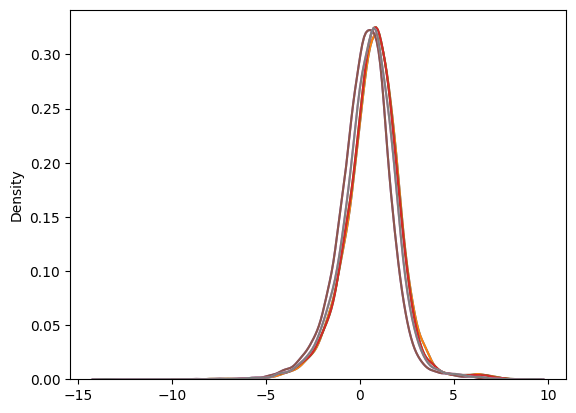

In [308]:
for seq in np.log(resid_variance):
    
    sns.kdeplot(seq)

In [312]:
model.estimates['total_umi']

,total_umi
memento_group^D1^Th0,12759175.0
memento_group^D1^UNS,3017591.0
memento_group^D2^Th0,7600856.0
memento_group^D2^UNS,2581775.0
memento_group^D3^Th0,13963183.0
memento_group^D3^UNS,1111372.0
memento_group^D4^Th0,13658274.0
memento_group^D4^UNS,1786736.0


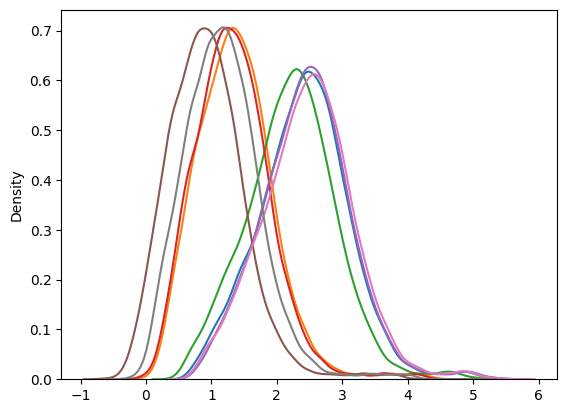

In [313]:
for seq in np.log10(pred):
     
    sns.kdeplot(seq)

0.8389224384006054


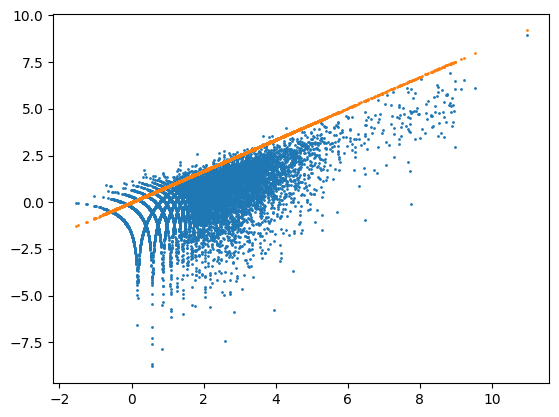

In [287]:
idx = 5

x = np.log(pred[idx]) 
y = np.log((resid_variance)[idx])
alpha = np.quantile(y[x>6]/x[x>6], 1)

plt.scatter(
    x,
    y,
    s=1
)
plt.scatter(
    x,
    alpha*x, s=1)
print(alpha)

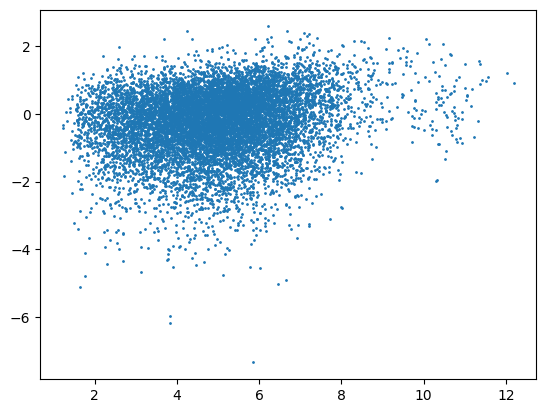

In [112]:
plt.scatter(
    np.log(mean_hat.mean(axis=0)),
    np.log((resid_variance / predicted_var).sum(axis=0)/2),
    s=1
)

In [100]:
alpha_estimates = ((resid_variance-mean_hat)/mean_hat**2).mean(axis=0)
np.median(alpha_estimates)

-0.0161810000010927

In [386]:
np.median(resid_variance)

3.4264098789588595

In [389]:
alpha_estimates = (resid_variance/mean_hat**2).mean(axis=0)
np.median(alpha_estimates)

0.017504257122268614

In [391]:
stats.linregress(np.log(mean_hat.mean(axis=0)), np.log(resid_variance.mean(axis=0)))

LinregressResult(slope=1.0959312624331319, intercept=-3.398392233597789, rvalue=0.7746406827395166, pvalue=0.0, stderr=0.00859848467408553, intercept_stderr=0.044501588546848735)

In [392]:

np.exp(-3.4)

0.03337326996032608

In [393]:
stats.linregress(np.log(mean_hat.mean(axis=0)), np.log(resid_variance.mean(axis=0)))

LinregressResult(slope=1.0959312624331319, intercept=-3.398392233597789, rvalue=0.7746406827395166, pvalue=0.0, stderr=0.00859848467408553, intercept_stderr=0.044501588546848735)

In [396]:
x,y = np.log(mean_hat.mean(axis=0)), np.log(resid_variance.mean(axis=0))

In [397]:
x_high = x[x > np.quantile(x, 0.95)]
y_high = y[x > np.quantile(x, 0.95)]

In [398]:
stats.linregress(x, y)

LinregressResult(slope=1.0959312624331319, intercept=-3.398392233597789, rvalue=0.7746406827395166, pvalue=0.0, stderr=0.00859848467408553, intercept_stderr=0.044501588546848735)

In [399]:
1.7304783571937772-1.1258140940408377

0.6046642631529395

In [403]:
idx = 0 
slopes = []
for idx in range(mean_hat.shape[0]):

    x,y = np.log(mean_hat[idx]), np.log(resid_variance[idx])
    
    x_high = x[x > np.quantile(x, 0.95)]
    y_high = y[x > np.quantile(x, 0.95)]
    slopes.append(stats.linregress(x_high,y_high)[0])
    print(idx, 'slope', stats.linregress(x_high,y_high)[0])

# plt.scatter(x, 2*x-15, s=1)
# plt.scatter(x, 2.5*x-15, s=1)
# plt.scatter(np.log(mean_hat.mean(axis=0)), np.log(mean_hat.mean(axis=0) + 0.4*mean_hat.mean(axis=0)**2)-5)
# plt.scatter(np.log(mean_hat.mean(axis=0)), np.log(mean_hat.mean(axis=0) + 0.01*mean_hat.mean(axis=0)**2.5)-7)

# plt.scatter(np.log(mean_hat.mean(axis=0)), np.log(mean_hat.mean(axis=0) + 0.001*mean_hat.mean(axis=0)**2)-3)

0 slope 2.472539943458982
1 slope 2.0417930436942955
2 slope 2.5340037586269255
3 slope 2.1071988373642645
4 slope 1.9983703006729667
5 slope 1.6167335211008778
6 slope 2.1364352675979035
7 slope 1.6817591425713259


[autoreload of memento.model.rna failed: Traceback (most recent call last):
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 271, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment only s

In [402]:
list(np.array(slopes)-np.array(slopes).min()+2)

[2.1429457276711066,
 2.5120682437274526,
 2.09079768469843,
 2.4462770013926765,
 2.0,
 2.3077062942614184,
 2.039225366369445,
 2.410261892837851]

In [347]:
s = np.array(slopes)

In [349]:
s.min()-s.max()

-0.5282548204602311

In [346]:
np.nan(np.array(slopes))

0.035077072137817286

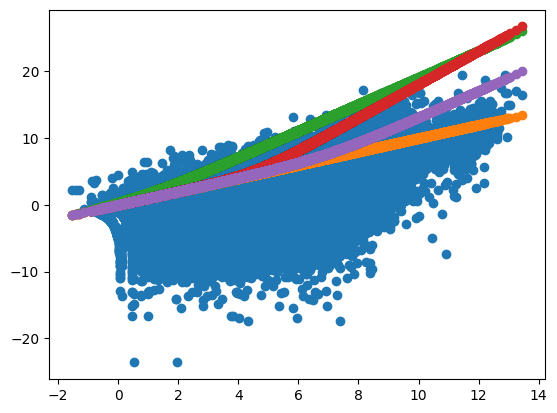

In [74]:
plt.scatter(np.log(mean_hat), np.log(resid_variance))
plt.scatter(np.log(mean_hat), np.log(mean_hat))

# plt.scatter(np.log(mean_hat), np.log(mean_hat + dispersion.iloc[:, 1].values*mean_hat**2))
plt.scatter(np.log(mean_hat), np.log(mean_hat + 0.4*mean_hat**2))
plt.scatter(np.log(mean_hat), np.log(mean_hat + 0.001*mean_hat**2.5))
plt.scatter(np.log(mean_hat), np.log(mean_hat + 0.001*mean_hat**2))



In [904]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [912]:
expr

,FO538757.2,AP006222.2,RP11-206L10.9,LINC00115,FAM41C,NOC2L,ISG15,C1orf159,TNFRSF4,SDF4,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1,AC007325.4,AL354822.1,AC240274.1
memento_group^D1^iTreg,497.572746,555.198097,147.387918,90.870746,33.245395,1121.477993,45721.283631,83.113488,5239.474260,1822.955829,...,36593.206330,4996.782876,179567.244098,22699.955739,9533.671120,41622.126421,247.124103,28.812676,55.408992,32.137215
memento_group^D1^UNS,38.919872,16.617473,6.996831,3.498415,4.810321,60.347666,83.961971,3.935717,2.186510,58.161157,...,2665.355269,234.831137,4627.529032,551.000433,97.955633,2448.453511,12.244454,2.623812,2.623812,4.373019
memento_group^D2^UNS,40.392055,11.612716,5.553908,3.534305,4.039205,55.539075,71.695897,4.544106,1.514702,67.151791,...,3005.168878,177.220141,4363.856622,416.543065,87.347819,2013.039032,31.303842,1.514702,4.039205,6.058808
memento_group^D3^iTreg,730.433856,1038.793730,175.181191,166.985580,61.467085,1200.657053,34438.983061,76.833856,5648.825077,1963.873354,...,36444.858922,4420.507836,163790.315934,18446.272094,9767.119746,38096.274596,243.819436,86.053918,59.418182,43.026959
memento_group^D3^UNS,18.678686,8.872376,4.202704,1.867869,3.268770,22.881390,31.286799,1.400901,0.933934,19.145653,...,1401.835388,105.534576,2006.557849,177.914485,28.951963,1201.039513,8.405409,2.801803,2.334836,1.867869
memento_group^D4^iTreg,830.034227,988.853625,190.119572,124.041428,59.122550,1829.321243,120307.433006,103.174646,6533.621373,2141.163711,...,42567.076504,3534.601058,171577.116970,18913.419569,16594.888209,36224.733969,525.147353,54.485487,92.741254,37.096502
memento_group^D4^UNS,29.667368,10.360033,3.767285,2.825464,0.941821,41.911043,50.387434,2.825464,1.412732,45.678328,...,1237.082143,76.758428,1829.016765,193.544256,41.440133,892.375584,14.598229,1.883642,4.238195,3.296374


In [910]:
counts = expr.T.round()
dds = DeseqDataSet(
    counts=counts,
    clinical=design_matrix,
    design_factors=["group", "condition"],
    refit_cooks=True,
    n_cpus=8,
)

ValueError: Index of obs must match index of X.

In [39]:
pred_df = pd.DataFrame(pred_list, index=expr.columns, columns=expr.index).T

In [40]:
v_hat = np.sqrt((pred_df-expr)**2)

In [41]:
x = np.log(pred_df.values.ravel())
y = np.log(v_hat.values.ravel())

In [20]:
x = pred_df.values.mean(axis=0)
y = v_hat.values.mean(axis=0)

In [42]:
slope, inter , _, _, _ = stats.linregress(np.log(x),np.log(y))

2023-07-09 14:44:52 1533054 WARNING  /tmp/ipykernel_1533054/2039125209.py:1: RuntimeWarning: invalid value encountered in log
  slope, inter , _, _, _ = stats.linregress(np.log(x),np.log(y))



2023-07-09 14:45:02 1533054 WARNING  /tmp/ipykernel_1533054/2003753684.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(x), np.log(y), s=1, alpha=0.1)



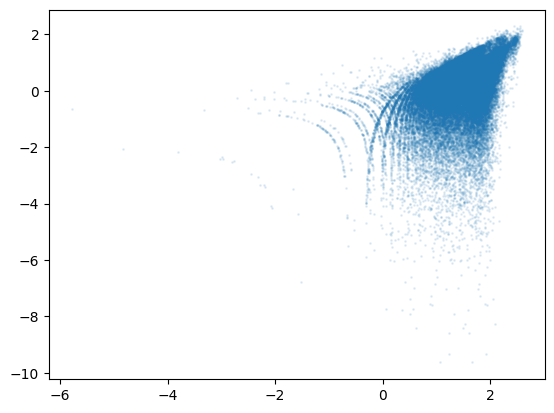

In [45]:
plt.scatter(np.log(x), np.log(y), s=1, alpha=0.1)
# plt.scatter(np.log(x), np.log(x)*slope+inter, s=1, alpha=0.1)
# plt.scatter(np.log(x), np.log( (x+0.4*x**2)/1000  ), s=1, alpha=0.1)

# plt.scatter(np.log(x), np.log(x+0.001*x**2), s=1, alpha=0.1)

In [223]:
genewise = np.exp(np.log(v*multiplier) - np.log(nb_var_func(m,d)))

In [222]:
np.exp(genewise)

array([1.271629  , 1.11134869, 1.04962238, ..., 0.60047011, 0.79468165,
       0.60047011])

In [184]:
v

array([2.70721086e-04, 1.07242697e-04, 7.78187206e-06, ...,
       1.96131613e-06, 7.89590578e-06, 4.09117807e-06])

In [182]:
multiplier

810.596388419811

In [179]:
multiplier

552.0255881858686

In [180]:
sample_dispersions

array([ 0.49107242, -1.61803398,  0.41330406, -1.61803398,  0.5087693 ,
       -1.61803398,  0.46154569, -1.61803398])

In [150]:
expr = model.estimates['mean']

expr_var = model.estimates['se_mean'].iloc[0]

 

In [151]:
lowexpr = expr[expr < np.quantile(expr, 0.3)]
lowexpr_var = expr_var[expr < np.quantile(expr, 0.3)]
multiplier = (lowexpr/lowexpr_var).median()

In [152]:
def empirical_var_func(x, alpha):
    
    return np.sqrt(x)*(x+alpha*x**2)

def nb_var_func(x, alpha):
    
    return (x+alpha*x**2)/multiplier

def objective(alpha):
    
    return ((np.log(expr_var) - np.log(nb_var_func(expr, alpha)))**2).mean()

In [153]:
from scipy.optimize import minimize_scalar

In [154]:
res = minimize_scalar(objective)

In [155]:
pred_empirical_var = empirical_var_func(expr, 0.01)
pred_nb_var = nb_var_func(expr, res.x)

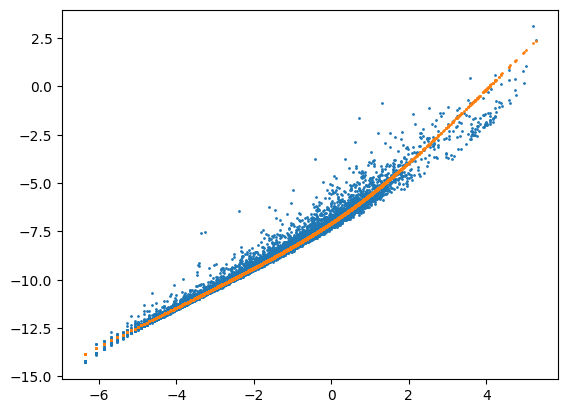

In [156]:
plt.scatter(np.log(expr), np.log(expr_var), s=1)

# plt.scatter(np.log(expr), np.log(pred_empirical_var)-7.5, s=1)

plt.scatter(np.log(expr), np.log(pred_nb_var), s=1)

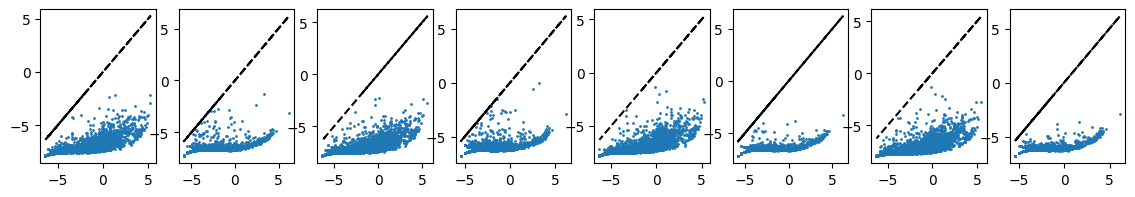

In [120]:
plt.figure(figsize=(14, 2))
for idx in range(expr.shape[0]):
    
    plt.subplot(1, expr.shape[0], idx+1)
    plt.scatter(np.log(expr.iloc[idx]), np.log(expr_se.iloc[idx])-np.log(expr.iloc[idx]), s=1)
    plt.plot(np.log(expr.iloc[idx]), np.log(expr.iloc[idx]), '--', color='k')

In [69]:
expr

,FO538757.2,AP006222.2,RP4-669L17.10,RP11-206L10.9,LINC00115,FAM41C,NOC2L,KLHL17,ISG15,C1orf159,...,DLL3,B3GNT8,NLGN4Y,RFPL1S,NEFH,RP6-109B7.5,ODF3B,LRRC3,RP11-563D10.1,RPS6KA6
memento_group^D1^Th0,341.233705,280.170831,13.170424,70.641363,17.959669,28.735470,929.113526,23.946225,35264.408101,76.627920,...,41.905894,5.986556,40.708582,8.381179,198.753667,19.156980,420.256247,33.524715,10.775801,3.591934
memento_group^D1^UNS,71.828265,32.547183,2.805792,14.590116,7.295058,8.978533,97.080389,5.611583,164.419388,6.733900,...,1.683475,2.244633,3.928108,2.244633,2.805792,1.683475,2.244633,1.122317,2.805792,1.683475
memento_group^D2^Th0,357.710382,362.820531,12.775371,80.484836,28.105816,54.934094,1140.840613,25.550742,15519.520450,97.092818,...,95.815281,5.110148,42.158724,12.775371,210.793618,15.330445,365.375605,35.771038,7.665222,5.110148
memento_group^D2^UNS,40.883264,15.600193,1.075875,10.758754,4.303502,4.303502,56.483457,4.841439,93.601158,6.455252,...,1.075875,3.765564,1.075875,1.613813,2.689688,1.075875,4.303502,1.075875,2.151751,1.613813
memento_group^D3^Th0,373.494175,430.588826,4.757888,82.073561,42.820988,45.199932,814.788249,26.168382,26867.791191,61.852539,...,52.336763,7.136831,26.168382,7.136831,139.168212,8.326303,381.820479,41.631516,4.757888,3.568416
memento_group^D3^UNS,78.988197,26.889599,2.240800,10.643800,5.041800,10.083600,112.600195,3.361200,161.897793,6.722400,...,1.680600,1.120400,2.801000,1.680600,1.120400,1.680600,2.240800,1.680600,3.361200,1.120400
memento_group^D4^Th0,588.350499,595.223753,5.498603,147.087625,49.487425,67.357884,1649.580840,41.239521,78499.428210,114.096008,...,239.189222,12.371856,57.735329,10.997206,250.186427,39.864870,848.159482,118.219960,5.498603,5.498603
memento_group^D4^UNS,52.002225,11.258214,3.752738,5.361054,3.216632,5.361054,60.579912,1.608316,85.240761,5.361054,...,1.072211,1.072211,2.144422,2.680527,1.608316,1.072211,2.680527,1.072211,1.608316,1.072211


In [ ]:
dd

In [54]:
weights['GAPDH']

memento_group^D1^Th0    0.277432
memento_group^D1^UNS    0.665459
memento_group^D2^Th0    0.308361
memento_group^D2^UNS    0.721924
memento_group^D3^Th0    0.290212
memento_group^D3^UNS    0.676479
memento_group^D4^Th0    0.276313
memento_group^D4^UNS    0.720073
Name: GAPDH, dtype: float64

In [56]:
genewise_weights = weights.mean(axis=0)

In [57]:
genewise_weights['GAPDH']

0.49203180144984565

<Axes: ylabel='Density'>

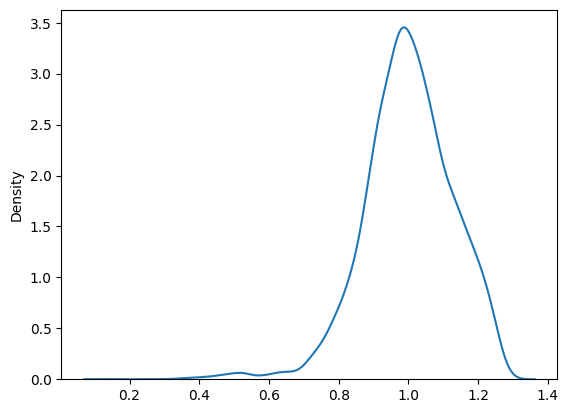

In [58]:
sns.kdeplot(genewise_weights)

In [13]:
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['mouse'] = df.index.str.split('^').str[1]
df['stim'] = df.index.str.split('^').str[2]

cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
stim_df = (df[['stim']]==stim).astype(float)
cov_df = sm.add_constant(cov_df)

glm_result = model.differential_mean(
    covariates=cov_df, 
    treatments=stim_df,
    family='WGLM',
    dispersions=dispersions,
    verbose=2,
    n_jobs=5)

_, glm_result['fdr'] = fdrcorrection(glm_result['pval'])
glm_result.to_csv(data_path + 'sc_results/{}_{}_repro.csv'.format(dataset, trial))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 3574 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 10070 tasks      | elapsed:    9.9s
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
[Parallel(n_jobs=5)]: Done 12029 out of 12029 | elapsed:   11.8s finished


In [17]:
glm_result.sort_values('fdr')

,treatment,coef,pval,fdr
gene,,,,
CDT1,stim,5.844626,4.074694e-290,4.901449e-286
CCNA2,stim,5.437427,4.010531e-243,2.412134e-239
BIRC5,stim,5.485304,1.288913e-222,5.168111e-219
NCAPG,stim,4.976096,7.946012e-221,2.389564e-217
RMI2,stim,4.825368,1.859478e-212,4.473532e-209
...,...,...,...,...
ENTPD1,stim,1.542136,1.000000e+00,1.000000e+00
HOXB2,stim,-0.000173,9.996403e-01,1.000000e+00
C21orf33,stim,0.000000,1.000000e+00,1.000000e+00


In [19]:
glm_result.loc['GAPDH'].values

array(['stim', 3.1643372010235087, 1.28032772346962e-10,
       3.0648879971375236e-10], dtype=object)

### RUn tt-est and MWU

In [75]:
def safe_fdr(x):
    fdr = np.ones(x.shape[0])
    _, fdr[np.isfinite(x)] = fdrcorrection(x[np.isfinite(x)])
    return fdr

for dataset in datasets:
    for trial in range(1,2):
        print('working on', dataset)

        # stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path + 'single_cell/{}_{}.h5ad'.format(dataset, trial))
        labels = adata.obs['cytokine.condition'].drop_duplicates().tolist()

        data1 = adata[adata.obs['cytokine.condition'] ==labels[0]].X.todense()
        data2 = adata[adata.obs['cytokine.condition'] ==labels[1]].X.todense()

        statistic, pvalue = stats.ttest_ind(data1, data2, axis=0)

        logfc = data1.mean(axis=0) - data2.mean(axis=0)

        ttest_result = pd.DataFrame(
            zip(logfc.A1, pvalue, safe_fdr(pvalue)), 
            index=adata.var.index,
            columns=['logFC', 'PValue', 'FDR'])
        ttest_result.to_csv(data_path + 'sc_results/{}_{}_t-test.csv'.format(dataset, trial))

        mwu_stat, mwu_pval = stats.mannwhitneyu(data1, data2, axis=0)
        mwu_result = pd.DataFrame(
            zip(logfc.A1, mwu_pval, safe_fdr(mwu_pval)), 
            index=adata.var.index,
            columns=['logFC', 'PValue', 'FDR'])
        mwu_result.to_csv(data_path + 'sc_results/{}_{}_MWU.csv'.format(dataset, trial))

working on CD4_Memory-Th0
working on CD4_Memory-Th2
working on CD4_Memory-Th17
working on CD4_Memory-iTreg
working on CD4_Naive-Th0
working on CD4_Naive-Th2
working on CD4_Naive-Th17
working on CD4_Naive-iTreg


In [70]:
design

DesignMatrix with shape (7, 5)
  Intercept  ind[T.D2]  ind[T.D3]  ind[T.D4]  ct
          1          0          0          0   1
          1          0          0          0   0
          1          1          0          0   0
          1          0          1          0   1
          1          0          1          0   0
          1          0          0          1   1
          1          0          0          1   0
  Terms:
    'Intercept' (column 0)
    'ind' (columns 1:4)
    'ct' (column 4)

In [52]:
totals

array([20453175.08590253,  3857003.2564052 , 20857495.18365347,
        2338389.72324883, 18823216.80367367,  3732974.70533321,
       28151555.14636867,  2354873.10729187])

In [53]:
dataset

'CD4_Memory-Th0'

In [54]:
idx

9519

In [56]:
scaled_means.iloc[:, idx]

0    483.093552
1      5.394017
2     38.001428
3     97.792908
4     27.311584
5     13.206822
6     33.470755
7     79.735536
Name: MTRNR2L1, dtype: float64

In [33]:
design

DesignMatrix with shape (8, 5)
  Intercept  ind[T.D2]  ind[T.D3]  ind[T.D4]  ct
          1          0          0          0   1
          1          0          0          0   0
          1          1          0          0   1
          1          1          0          0   0
          1          0          1          0   1
          1          0          1          0   0
          1          0          0          1   1
          1          0          0          1   0
  Terms:
    'Intercept' (column 0)
    'ind' (columns 1:4)
    'ct' (column 4)

In [36]:
weights

Gene,FO538757.2,AP006222.2,RP11-206L10.9,NOC2L,ISG15,SDF4,B3GALT6,UBE2J2,ACAP3,CPSF3L,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1
0,0.175882,0.189918,0.316612,0.107929,0.003255,0.106241,0.548434,0.129368,0.240060,0.125772,...,0.498434,0.004245,0.002694,0.008942,0.041943,0.002243,0.014872,0.029733,0.006323,0.269635
1,0.526103,0.430368,0.481983,0.340468,0.197334,0.256486,0.614926,0.253410,0.547080,0.292842,...,0.543599,0.023869,0.015807,0.026462,0.106650,0.018694,0.068735,0.160795,0.025417,0.477404
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.231916,0.599702,1.028791,0.245167,0.149812,0.271725,0.574552,0.281538,0.316310,0.341576,...,0.342683,0.020453,0.019116,0.023989,0.120082,0.021157,0.090077,0.171027,0.030226,0.303191
4,0.192648,0.137048,0.601480,0.114311,0.002999,0.085146,0.287437,0.161695,0.216897,0.133580,...,0.347202,0.006053,0.002958,0.010878,0.053367,0.002908,0.019480,0.041335,0.009147,0.249143
5,0.344229,0.467455,0.649016,0.249929,0.200633,0.234944,0.575523,0.252357,0.465758,0.324595,...,0.504536,0.019205,0.015615,0.022688,0.128699,0.018262,0.083069,0.200419,0.023527,0.469300
6,0.156977,0.142387,0.228027,0.106110,0.003479,0.088724,0.324586,0.127284,0.322641,0.131425,...,0.331563,0.005402,0.002544,0.009792,0.062447,0.002610,0.018423,0.018876,0.008590,0.220013
7,0.297986,0.586409,0.769669,0.228430,0.168349,0.234615,0.438616,0.184553,0.436684,0.331795,...,0.500247,0.025498,0.027182,0.033474,0.206970,0.023675,0.104392,0.292843,0.044026,0.289309


In [35]:
scaled_means

Gene,FO538757.2,AP006222.2,RP11-206L10.9,NOC2L,ISG15,SDF4,B3GALT6,UBE2J2,ACAP3,CPSF3L,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1
0,26.580271,28.477228,9.166770,61.244877,2697.981470,75.121549,5.971062,65.909435,14.915811,58.012672,...,4.814692,2940.712183,5129.097175,1668.880278,232.469719,8195.446272,955.358719,407.607758,1771.489970,10.352074
1,4.868210,6.125504,3.584307,11.227320,26.416029,16.241032,2.029506,14.919105,3.415609,10.540060,...,3.372572,1004.991345,1341.521078,721.203308,71.888429,1340.550952,159.763806,21.336843,665.023269,4.356726
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,17.255712,3.268531,1.325556,18.871645,31.905155,14.801774,3.270195,13.114347,11.206776,9.282823,...,4.583885,1282.449598,1276.416181,940.002858,64.778586,1403.387756,128.267884,29.519061,647.627624,11.010394
4,26.458071,43.504049,4.031524,55.580922,1589.492575,92.912437,7.028116,39.399254,11.581210,40.899940,...,8.438977,2053.291805,4556.550603,1294.327374,181.557757,6514.940799,645.908046,332.822909,1337.246263,12.615007
5,10.040101,5.843941,2.379377,19.219009,25.112033,17.072694,3.291453,13.533838,5.177834,10.916390,...,4.919544,1586.017112,1694.755920,1058.400092,72.493620,1589.525898,123.865474,24.355055,939.636343,5.936413
6,34.059567,38.519652,10.149671,65.786875,4214.179649,77.141735,8.853274,61.929655,10.444494,51.991910,...,6.949855,2122.180282,4317.609648,1506.982087,128.724081,6230.474109,705.383229,618.772160,1290.068124,15.268535
7,11.918690,3.287267,2.234547,21.990299,29.492231,18.695332,4.567248,20.479965,6.135121,10.946109,...,4.302498,712.513564,860.598315,537.503477,23.761321,844.195493,91.123197,12.288590,384.408625,11.262069


In [16]:
design

DesignMatrix with shape (8, 5)
  Intercept  ind[T.D2]  ind[T.D3]  ind[T.D4]  ct
          1          0          0          0   0
          1          0          0          0   0
          1          1          0          0   0
          1          1          0          0   0
          1          0          1          0   0
          1          0          1          0   0
          1          0          0          1   0
          1          0          0          1   0
  Terms:
    'Intercept' (column 0)
    'ind' (columns 1:4)
    'ct' (column 4)

### Use the sampling dispersions directly and compute log-likelihood

In [118]:
# Add the average sampling dispersion to edgeR dispersion
def _ll_nbin(fit, alpha):
    
    gamma_ln = gammaln
    endog = fit.model.endog
    mu = fit.predict()
    size = 1/alpha
    prob = size/(size+mu)
    coeff = (gamma_ln(size+endog) - gamma_ln(endog+1) -
             gamma_ln(size))
    llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
    return llf.sum()

for file in files:
    for trial in range(1,2):
        print('working on', file)

        stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path +'replicates/' + file + '_{}.h5ad'.format(trial))

        dispersions = pd.read_csv(data_path + '../results/{}_{}_dispersions.csv'.format(file, trial))
        gene_list = dispersions['gene'].tolist()
        dispersions = dispersions['dispersion'].tolist()

        groups = adata.obs[['replicate', 'label']].drop_duplicates().reset_index()
        
        expr = []
        sampling_dispersions = []
        meta = []
        for idx, row in groups.iterrows():

            ind = row['replicate']
            condition = row['label']

            # Compute everything
            group_adata =  adata[(adata.obs['replicate']==ind) & (adata.obs['label']==condition)].copy()
            data = group_adata.X.toarray()
            means = data.mean(axis=0)
            variances = data.var(axis=0)
            count_disp = (variances-means)/(means**2+1e-8)
            sum_var = variances*data.shape[0]
            sum_disp = count_disp/data.shape[0]
            sums = data.sum(axis=0)
            
            # Gather everything
            expr.append(sums)
            sampling_dispersions.append(sum_var)
            meta.append((ind, int(stim in condition)))
            
        expr = pd.DataFrame(expr, columns=adata.var.index)
        sampling_dispersions = pd.DataFrame(sampling_dispersions, columns=adata.var.index).clip(lower=0)+1e-8
        meta = pd.DataFrame(meta, columns=['replicate', 'label'])

        # Filter and re-order by gene_list
        libsize = expr.values.sum(axis=1)
        expr = expr[gene_list]
        sampling_dispersions = sampling_dispersions[gene_list]
        weights = np.sqrt(1/sampling_dispersions)
        weights = weights/weights.values.mean()
        
        # Compute the dispersions
        genewise_additional_disp = dispersions - sampling_dispersions.clip(lower=0).mean(axis=0).values
        genewise_additional_disp[genewise_additional_disp < 0] = 1e-8
        
        # Get the design matrix
        design = dmatrix('replicate+label', meta)
    
        results = []
        for idx in range(len(gene_list)):
            model = sm.GLM(
                expr.iloc[:, [idx]], 
                design,
                var_weights=1/weights.iloc[:, idx],
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            res_model = sm.GLM(
                expr.iloc[:, [idx]], 
                design[:, :-1] , 
                var_weights=1/weights.iloc[:, idx],
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            fit = model.fit()
            res_fit = res_model.fit()
            
            pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
            results.append((fit.params[-1], pv))
        results = pd.DataFrame(results, columns=['logFC', 'PValue'], index=gene_list)
        _, results['FDR'] = fdrcorrection(results['PValue'])

        results.index = gene_list
        results.to_csv(data_path + '../results/{}_{}_memento_var_weights.csv'.format(file, trial))


working on Hagai2018_mouse-lps
working on Hagai2018_mouse-pic
working on Hagai2018_pig-lps
working on Hagai2018_rabbit-lps
working on Hagai2018_rat-lps
working on Hagai2018_rat-pic


In [116]:
weights

,0610009B22Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610030E20Rik,0610037L13Rik,1110004F10Rik,1110008P14Rik,1110012L19Rik,1110032A03Rik,...,Zswim8,Zup1,Zw10,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
0,0.648929,1.248106,1.725492,0.102687,0.988816,0.598772,0.091690,0.049313,2.364832,0.952753,...,1.371545,0.510589,5.731099,0.480246,1.165244,3.860122,1.147391,0.017482,0.558576,0.771494
1,0.232278,0.678318,0.748864,0.089406,1.923451,0.843948,0.096214,0.107431,5.731099,1.021178,...,0.843948,5.731099,1.725492,0.561648,5.731099,1.991659,0.579317,0.203091,0.493756,1.063727
2,0.442416,0.624053,1.200102,0.056606,0.463406,0.464940,0.065115,0.038944,1.371545,0.993188,...,0.670224,0.620263,5.731099,0.226654,2.364832,1.063727,1.248106,0.064572,0.604247,0.429394
3,0.221339,0.677092,0.645943,0.025161,0.344675,0.670224,0.109153,0.052246,1.526217,1.063727,...,0.800068,1.470282,0.952753,0.569911,5.731099,0.894343,0.453673,0.220297,0.677092,0.464940
4,0.404645,0.333223,0.473764,0.068615,0.412370,0.301071,0.074807,0.039276,2.925248,5.731099,...,0.456810,0.545554,5.731099,0.163009,1.991659,1.725492,1.526217,0.049106,0.577827,0.645943
5,0.315887,0.598772,0.624053,0.032583,0.558576,0.485015,0.084010,0.053756,0.835785,0.697266,...,0.598772,2.925248,1.470282,0.353682,2.364832,1.991659,0.800068,0.124548,0.677092,0.336417


In [102]:
(genewise_additional_disp>0).mean()

0.9018544215970733

In [85]:
_ll_nbin(fit, dispersions[idx])

-17.219189890231956

In [86]:
_ll_nbin(fit, sampling_dispersions.iloc[:, idx].values+1e-8)

-15.515143707455543

### Vanilla (memento)

In [23]:
# add dispersions

for file in files:
    for trial in range(1,2):
        print('working on', file)

        stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path +'replicates/' + file + '_{}.h5ad'.format(trial))

        dispersions = pd.read_csv(data_path + '../results/{}_{}_dispersions.csv'.format(file, trial))
        gene_list = dispersions['gene'].tolist()
        dispersions = dispersions['dispersion'].tolist()

        groups = adata.obs[['replicate', 'label']].drop_duplicates().reset_index()
        
        expr = []
        meta = []
        for idx, row in groups.iterrows():

            ind = row['replicate']
            condition = row['label']

            # Compute everything
            group_adata =  adata[(adata.obs['replicate']==ind) & (adata.obs['label']==condition)].copy()
            data = group_adata.X.toarray()
            sums = data.sum(axis=0)
            
            # Gather everything
            expr.append(sums) 
            meta.append((ind, int(stim in condition)))
            
        expr = pd.DataFrame(expr, columns=adata.var.index)
        meta = pd.DataFrame(meta, columns=['replicate', 'label'])

        # Filter and re-order by gene_list
        libsize = expr.values.sum(axis=1)
        expr = expr[gene_list]
        
        # Get the design matrix
        design = dmatrix('replicate+label', meta)


        results = []
        for idx in range(len(gene_list)):
            model = sm.GLM(
                expr.iloc[:, [idx]], 
                design , 
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            res_model = sm.GLM(
                expr.iloc[:, [idx]], design[:, :-1] , 
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            fit = model.fit()
            res_fit = res_model.fit()
            pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
            results.append((fit.params[-1], pv))
        results = pd.DataFrame(results, columns=['logFC', 'PValue'], index=gene_list)
        _, results['FDR'] = fdrcorrection(results['PValue'])

        results.index = gene_list
        results.to_csv(data_path + '../results/{}_{}_memento.csv'.format(file, trial))


working on Hagai2018_mouse-lps
working on Hagai2018_mouse-pic
working on Hagai2018_pig-lps
working on Hagai2018_rabbit-lps
working on Hagai2018_rat-lps
working on Hagai2018_rat-pic


In [61]:
fit.predict(design)*libsize

array([23.08607315, 25.85243233, 31.22370082, 37.75068135, 14.93534009,
       26.36355818])

In [62]:
expr.iloc[:, [idx]]

,Zzz3
0,22.0
1,27.0
2,31.0
3,38.0
4,16.0
5,25.0


In [20]:
res_fit.df_resid-fit.df_resid

1

In [88]:
file

'Hagai2018_mouse-lps'

In [9]:
%%time


for file in files:
    for trial in range(1,11):
        print('working on', file)

        stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path +'replicates/' + file + '_{}.h5ad'.format(trial))
        adata.obs['q'] = 0.07
        memento.setup_memento(adata, q_column='q', trim_percent=0.99, filter_mean_thresh=0.00000001, estimator_type='sum')
        adata.obs['memento_size_factor'] = adata.X.sum(axis=1).A1
        memento.create_groups(adata, label_columns=['replicate', 'label'])
        dispersions = pd.read_csv(data_path + '../results/{}_{}_dispersions.csv'.format(file, trial))
        gene_list = dispersions['gene'].tolist()
        dispersions = dispersions['dispersion'].tolist()

        # adata = adata[:, gene_list].copy()

        memento.compute_1d_moments(adata, gene_list=gene_list)
        adata.var['dispersion'] = dispersions

        meta = pd.get_dummies(memento.get_groups(adata), drop_first=True)
        cov = meta.iloc[:, [0, 1]].astype(int)
        cov['intercept'] = 1
        treatment = meta.iloc[:, [2]].astype(int)

        memento.ht_1d_moments(
            adata,
            covariate=cov,
            treatment=treatment,
            num_boot=5000,
            verbose=2,
            num_cpus=93)
        results = memento.get_1d_ht_result(adata)
        results['FDR'] = memento.util._fdrcorrect(results['de_pval'])
        results.to_csv(data_path + '../results/{}_{}_memento.csv'.format(file, trial), index=False)
        break
    break

working on Hagai2018_mouse-lps


[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done 179 tasks      | elapsed:   40.5s
[Parallel(n_jobs=93)]: Done 462 tasks      | elapsed:  1.5min
[Parallel(n_jobs=93)]: Done 827 tasks      | elapsed:  2.4min
[Parallel(n_jobs=93)]: Done 1272 tasks      | elapsed:  3.7min
Bad pipe message: %s [b'M:\xb7\xab\x86\xbf\xdb\x1bYY*f@\x93\x08\xda%\xbe \x1d\xa8\x05${\x16Bl-)\xbc\x9c\x19\xf2{NHV\x1e\xb6\x9e%qY\xec"\xa1\x01b \x08\x00\x00&\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\t\xc0\x13\xc0\n\xc0\x14\x00\x9c\x00\x9d\x00/\x005\xc0\x12\x00\n\x13\x01\x13\x02\x13\x03\x01\x00\x00\x89\x00\x00\x00\x0e\x00\x0c\x00\x00\tlocalhost']
[Parallel(n_jobs=93)]: Done 1799 tasks      | elapsed:  5.1min
[Parallel(n_jobs=93)]: Done 2406 tasks      | elapsed:  6.8min
[Parallel(n_jobs=93)]: Done 3095 tasks      | elapsed:  8.8min
[Parallel(n_jobs=93)]: Done 3864 tasks      | elapsed: 10.9min
[Parallel(n_jobs=93)]: Done 4715 tasks      | elapsed: 13.3min
[Parallel(n

CPU times: user 31.2 s, sys: 6.61 s, total: 37.8 s
Wall time: 22min 13s


In [89]:
scaled_means['Nlrp3']

0    1597.966263
1      20.087687
2     621.789328
3       3.101967
4     385.786913
5       7.007130
Name: Nlrp3, dtype: float64

In [90]:
weights['Nlrp3']

0    0.187828
1    1.192380
2    0.283577
3    0.765142
4    0.320115
5    1.177536
Name: Nlrp3, dtype: float64

In [95]:
1/(variances/scaled_means)['Nlrp3']

0    0.002180
1    0.013840
2    0.003291
3    0.008881
4    0.003715
5    0.013667
Name: Nlrp3, dtype: float64

In [85]:
temp = 1/np.sqrt(variances)
temp = temp/temp.values.mean()
temp['Nlrp3']

0    0.053459
1    1.201353
2    0.105303
3    2.448954
4    0.142039
5    2.021367
Name: Nlrp3, dtype: float64

In [68]:
'Nirp3' in gene_list

False

In [45]:
weighted_mean_glm_results.loc['Ccl5']

logFC     2.912061
PValue         0.0
FDR            0.0
gene          Ccl5
Name: Ccl5, dtype: object

In [44]:
weighted_mean_glm_results.query('gene == "Gbp3"')

,logFC,PValue,FDR,gene
Gbp3,3.550863,5.683614e-15,1.520324e-13,Gbp3


In [ ]:
weights

In [ ]:
dispersions

0610009B22Rik      0.936955
0610009L18Rik    263.080223
0610010F05Rik      4.270511
0610010K14Rik     14.793980
0610012G03Rik      0.000000
                    ...    
Zxdc              54.571092
Zyg11b            12.241629
Zyx                0.017547
Zzef1              1.545507
Zzz3               3.453833
Length: 8961, dtype: float64

In [66]:
weighted_mean_glm_results = []
for idx in range(len(gene_list)):
    model = sm.GLM(
        scaled_means.iloc[:, [idx]], 
        design , 
        exposure=totals,
        var_weights=weights.iloc[:, idx],
        family=sm.families.NegativeBinomial(alpha=0.05))
    res_model = sm.GLM(
        scaled_means.iloc[:, [idx]], design[:, :-1] , 
        exposure=totals,
        var_weights=weights.iloc[:, idx],
        family=sm.families.NegativeBinomial(alpha=0.05))
    fit = model.fit()
    res_fit = res_model.fit()
    pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
    weighted_mean_glm_results.append((fit.params[-1], pv))
weighted_mean_glm_results = pd.DataFrame(weighted_mean_glm_results, columns=['logFC', 'PValue'], index=gene_list)
_, weighted_mean_glm_results['FDR'] = fdrcorrection(weighted_mean_glm_results['PValue'])

(array([11098.,  1306.,   936.,   750.,   708.,   625.,   601.,   588.,
          517.,   552.]),
 array([5.36163695e-91, 9.99920244e-02, 1.99984049e-01, 2.99976073e-01,
        3.99968098e-01, 4.99960122e-01, 5.99952147e-01, 6.99944171e-01,
        7.99936195e-01, 8.99928220e-01, 9.99920244e-01]),
 <BarContainer object of 10 artists>)

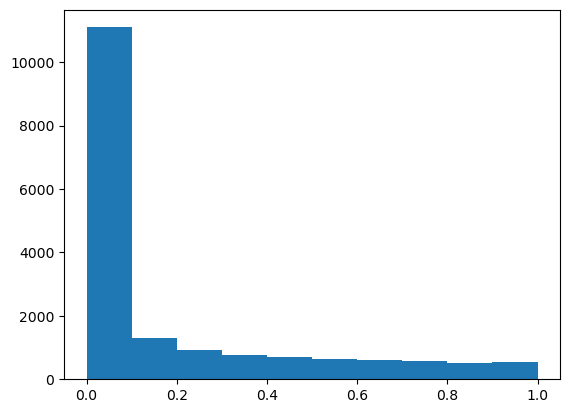

In [39]:
plt.hist(weighted_mean_glm_results['PValue'])

In [12]:
adata.obs[['replicate', 'label']].drop_duplicates().reset_index(drop=True)

,replicate,label
0,muc3838,24m
1,muc3839,24m
2,muc3840,3m
3,muc3841,3m
4,muc4166,24m
5,muc4167,24m
6,muc4168,24m
7,muc4169,3m
8,muc4170,3m
9,muc4172,3m


In [9]:
adata.obs.groupby(['replicate', 'label'])

replicate  label
muc3838    24m      155
muc3839    24m      131
muc3840    3m       293
muc3841    3m       176
muc4166    24m      252
muc4167    24m      275
muc4168    24m       99
muc4169    3m       487
muc4170    3m       364
muc4172    3m       410
muc4173    3m       583
muc4174    24m      175
muc4175    24m      103
muc4654    3m       498
muc4657    3m       198
dtype: int64

In [ ]:
def sample_sum(data):
    
    s = data.sum(axis=0)
    return s

def scaled_mean_se2(data, sf, q):

    augmented_data = np.append(data, np.ones((1,data.shape[1])), axis=0)

    sf = np.append(sf, sf.mean())
    q = q.mean()
    X = augmented_data/sf.reshape(-1,1)

    naive_v = X.var(axis=0)
    naive_m = X.mean(axis=0)
    v = naive_v-(1-q)*(augmented_data/(sf**2-sf*(1-q)).reshape(-1,1)).mean(axis=0)
    variance_contributions = ((1-q)/sf).reshape(-1,1)*naive_m.reshape(1,-1) + v.reshape(1,-1)
    m = np.average( X, weights=1/variance_contributions, axis=0)
    m[~np.isfinite(m)] = naive_m[~np.isfinite(m)]
    m[m<0] = 0
    # return np.log(naive_m), v/data.shape[0]
    total = data.sum()
    # return m*total, v*total**2
    return m*total, (v/data.shape[0])*total**2